# SEC Filings

The data is provided in zipped text files. Unzip the file and place the 'SEC-filings' directory into the './data' directory. 

A related dataset in similar format is the conll2003 dataset, available from [HuggingFace](https://huggingface.co/datasets/conll2003). This could be used as a source of additional training data, but note it contains a different kind of text (different 'domain'). 

In [1]:
# Data Extraction
import data_loader
import warnings
import params as p

from sklearn.model_selection import train_test_split

# Other
import matplotlib.pyplot as plt
import nltk
from sklearn.exceptions import UndefinedMetricWarning
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_classification_report, flat_f1_score
from sklearn.metrics import make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter

import optuna

## Settings

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

## Import Data

In [ ]:
(
    train_sentences_ner, train_labels_ner, test_sentences_ner, test_labels_ner, val_sentences_ner, val_labels_ner,
    ) = data_loader.import_task2_data()

# Task 2 Answer

### Clean Data

In [6]:
def crf_word_preprocessing(word, ref):

    word_features = {
        'bias' : 1.0,
        f'word_{ref}_lower' : word.lower(),
        f'word_{ref}_end3' : word[-3:],
        f'word_{ref}_end2' : word[-2:],
        f'word_{ref}_beg' : word[:3],
        f'word_{ref}_isupper' : word.isupper(),
        f'word_{ref}_istitle' : word.istitle(),
        f'word_{ref}_isdigit' : word.isdigit(),
        f'word_{ref}_postag' : nltk.pos_tag([word])[0][1]
        }

    return word_features

In [7]:
def crf_sentence_preprocessing(sentence):

    sentence_features = []

    for idx in range(len(sentence)):

        word = sentence[idx]

        word_features = crf_word_preprocessing(word, 0)

        if idx > 0:
            word_features = {
                **word_features,
                **crf_word_preprocessing(sentence[idx - 1], -1)
                }
        else:
            word_features['BOS'] = True

        if idx < len(sentence) - 1:
            word_features = {
                **word_features,
                **crf_word_preprocessing(sentence[idx + 1], +1)
            }
        else:
            word_features['EOS'] = True

        sentence_features.append(word_features)

    return sentence_features

In [8]:
def crf_data_preprocessing(data):
    opt = [crf_sentence_preprocessing(sentence) for sentence in data]
    print('data:', len(data), 'out:', len(opt))
    return opt

### Preprocess Data

In [9]:
X_train = crf_data_preprocessing(train_sentences_ner)
X_test = crf_data_preprocessing(test_sentences_ner)
X_val = crf_data_preprocessing(val_sentences_ner)

data: 921 out: 921
data: 303 out: 303
data: 231 out: 231


### NER Modelling

In [10]:
tagger = CRF()
tagger.fit(
    X = X_train,
    y = train_labels_ner,
)

CRF(keep_tempfiles=None)

In [11]:
y_pred = tagger.predict(X_test)

In [12]:
labels = list(tagger.classes_)
labels.remove('O')
labels

['I-PER', 'I-ORG', 'I-LOC', 'I-MISC']

In [13]:
print('F1 Score (train):', flat_f1_score(train_labels_ner, tagger.predict(X_train), average='weighted', labels=labels))
print('F1 Score (test):', flat_f1_score(test_labels_ner, tagger.predict(X_test), average='weighted', labels=labels))

F1 Score (train): 0.9743416791115298
F1 Score (test): 0.672484905956292


### Tuning

In [39]:
warnings.simplefilter(action = 'ignore', category = UndefinedMetricWarning)

In [36]:
sampler = optuna.samplers.TPESampler(seed=p.RANDOM_STATE)
study = optuna.create_study(sampler = sampler, direction = 'maximize', study_name = 'NER_HyperParam_CV')

oscv_params = {
    'c2' : optuna.distributions.LogUniformDistribution(1e-4, 1)
}

# use the same metric for evaluation
f1_scorer = make_scorer(
    score_func = flat_f1_score,
    average = 'weighted',
    labels = labels
    )

oscv = optuna.integration.OptunaSearchCV(
    study = study,
    estimator = CRF(c1 = 1),
    param_distributions = oscv_params,
    cv = 10,
    n_jobs = -1,
    n_trials = 100,
    random_state = p.RANDOM_STATE,
    refit = True,
    scoring = f1_scorer,
    verbose = 1
)

oscv.fit(X_train, train_labels_ner)

[I 2022-04-17 12:21:47,658] A new study created in memory with name: NER_HyperParam_CV
/var/folders/2f/cwgmhyzx4fn5cwp5j_dpmsd00000gn/T/ipykernel_82357/4254402327.py:15: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  oscv = optuna.integration.OptunaSearchCV(
[I 2022-04-17 12:21:47,732] Searching the best hyperparameters using 921 samples...
/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
[I 2022-04-17 14:52:52,292] Trial 3 finished with value: 0.8336594825444632 and parameters: {'c2': 0.1202253479621472}. Best is trial 3 with value: 0.8336594825444632.
/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F

In [ ]:
tuned_crf = oscv.best_estimator_

In [ ]:
print('F1 Score (train):', flat_f1_score(train_labels_ner, tuned_crf.predict(X_train), average='weighted', labels=labels))
print('F1 Score (test):', flat_f1_score(test_labels_ner, tuned_crf.predict(X_test), average='weighted', labels=labels))

F1 Score (train): 0.9972332141235233
F1 Score (test): 0.6885407988576319


### Displaying Results

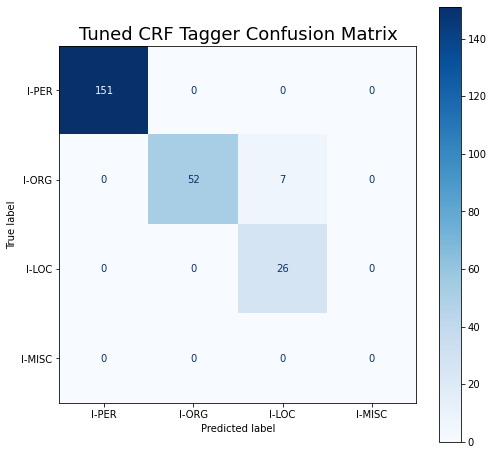

In [126]:
def create_confusion_matrix(y_true, y_pred, ner_labels):

    fig, ax = plt.subplots(1, 1, figsize = (8, 8))

    true = [label for sent_list in y_true for label in sent_list]
    pred = [label for sent_list in y_pred for label in sent_list]

    cm = confusion_matrix(true, pred, ner_labels)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ner_labels)
    disp.plot(cmap = 'Blues', ax = ax)

    plt.title('Tuned CRF Tagger Confusion Matrix', fontdict={'fontsize' : 18})

    plt.show()

create_confusion_matrix(
    y_pred=tuned_crf.predict(X_val),
    y_true=val_labels_ner,
    ner_labels = labels
)

### Feature Importance

In [130]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(tuned_crf.state_features_).most_common(10))

print("\nTop negative:")
print_state_features(Counter(tuned_crf.state_features_).most_common()[-10:])

Top positive:
13.091088 I-ORG    word_0_lower:bank
12.299236 I-PER    word_0_lower:borrower
11.672579 I-PER    word_0_lower:lender
9.572515 I-ORG    word_0_beg:Biz
8.576968 O        bias
8.524362 I-ORG    word_0_lower:vringo
7.845858 I-LOC    word_0_lower:commonwealth
6.755236 I-LOC    word_0_lower:massachusetts
6.593633 I-LOC    word_0_lower:northwest
6.074537 I-LOC    word_0_lower:east

Top negative:
-2.894897 O        word_0_beg:Air
-3.380172 O        word_0_end3:wer
-3.441826 I-LOC    word_1_end2:),
-3.537018 O        word_0_end2:an
-3.589350 O        word_0_end2:na
-3.611924 O        word_1_lower:corporation
-3.729980 O        word_0_beg:nor
-4.439450 O        word_0_istitle
-4.585986 O        word_0_beg:sou
-4.810937 O        word_0_postag:NNP
